# CS4-4 The generalizability of self-supervised learning model on EEG data

#### Group members:
Zihao Yang (460443043) 
Lin Liu (490254989) 
Jiang Wu (490334764) 
Zheng Li (490513901) 
Wei Cui (500429918) 
Peng Cao (500672086) 

#### Load Data

In [ ]:
import pandas as pd
import numpy as np
import random
import shutil
from tqdm import tqdm
import scipy.fft
from scipy.signal import hilbert, chirp
import zipfile
import os
from sklearn import preprocessing
import torch
import time
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
import torchvision.transforms as transforms
from torch.utils.data import random_split
from torch.utils.data import Dataset, DataLoader
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import copy

In [ ]:
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
def single_file_cup(file_name, window_size, over_lap_rate, start_ix, end_ix, keep_rate=1):
    single_data = pd.read_csv(file_name)
    time_steps = len(single_data)
    chosen_data = single_data.iloc[:,start_ix:end_ix]
    stack = []
    window_nums = int((time_steps - window_size)/(window_size*(1-over_lap_rate))) + 1
    for i in range(window_nums):
        start_index = int(window_size * (1-over_lap_rate))*i
        in_window = chosen_data.iloc[start_index:start_index+window_size,:]
        stack.append(np.array(in_window))
    keep_num = int(len(stack)*keep_rate)
    return stack[:keep_num]


#### Data preprocessing

#### Transformations

In [ ]:
def cutout(input_data, perc=.1):
    seq_len = input_data.shape[0]
    new_data = input_data.copy()
    start = np.random.randint(0, seq_len-int(perc * seq_len)-1)
    end = start + int(perc * seq_len)
    new_data[max(0, start):min(end, seq_len)] = 0
    return new_data

def jitter(input_data, sigma=0.03):
    jitter_data = np.random.normal(loc=0., scale=sigma, size=input_data.shape)
    new_data = input_data + jitter_data
    return new_data

def permutation(x, max_segments=5, seg_mode="equal"):
    orig_steps = np.arange(x.shape[1])
    num_segs = np.random.randint(1, max_segments, size=(x.shape[0]))
    ret = np.zeros_like(x)
    for i, pat in enumerate(x):
        if num_segs[i] > 1:
            if seg_mode == "random":
                split_points = np.random.choice(x.shape[1]-2, num_segs[i]-1, replace=False)
                split_points.sort()
                splits = np.split(orig_steps, split_points)
            else:
                splits = np.array_split(orig_steps, num_segs[i])
            warp = np.concatenate(np.random.permutation(splits)).ravel()
            ret[i] = pat[warp]
        else:
            ret[i] = pat
    return ret

def magnitude_warp_s(x, sigma=0.2, knot=4, plot=False): # https://github.com/haoyfan/SelfTime/blob/master/utils/augmentation.py
    from scipy.interpolate import CubicSpline
    orig_steps = np.arange(x.shape[0])
    random_warps = np.random.normal(loc=1.0, scale=sigma, size=(1, knot + 2, x.shape[1]))
    warp_steps = (np.ones((x.shape[1], 1)) * (np.linspace(0, x.shape[0] - 1., num=knot + 2))).T
    li = []
    for dim in range(x.shape[1]):
        li.append(CubicSpline(warp_steps[:, dim], random_warps[0, :, dim])(orig_steps))
    warper = np.array(li).T
    x_ = x * warper
    return x_

def time_warp_s(x, sigma=0.2, knot=4): # https://github.com/haoyfan/SelfTime/blob/master/utils/augmentation.py
    from scipy.interpolate import CubicSpline
    res = np.zeros_like(x)
    orig_steps = np.arange(x.shape[0])
    random_warps = np.random.normal(loc=1.0, scale=sigma, size=(1, knot + 2, x.shape[1]))
    warp_steps = (np.ones((x.shape[1], 1)) * (np.linspace(0, x.shape[0] - 1., num=knot + 2))).T
    for dim in range(x.shape[1]):
        time_warp = CubicSpline(warp_steps[:, dim],warp_steps[:, dim] * random_warps[0, :, dim])(orig_steps)
        scale = (x.shape[0] - 1) / time_warp[-1]
        res[:, dim] = np.interp(orig_steps, np.clip(scale * time_warp, 0, x.shape[0] - 1),x[:, dim]).T
    return res

def add_noise(data, noise_type, scale):
    data_size = data.shape
    if noise_type == 'broadcast':
        noise = np.random.normal(scale = scale, size=(data_size[0],1))
    elif noise_type == 'factor':
        noise = np.random.normal(scale = scale, size=data_size)
    return data + noise

def scale(data, scale):
    factor = np.random.normal(1.0,scale,size=(1,data.shape[1]))
    return np.multiply(data,factor)

def horizon_flip(data):
    return data[::-1]
  
def channel_shuffle(data):
    temple = data.T
    temple = temple[np.random.permutation(temple.shape[0]),:]
    return temple.T

def rotation(data,rotate_scale):
    rot = np.random.choice([rotate_scale],size=(1,data.shape[1]))
    rotate_axis = np.arange(data.shape[1])
    np.random.shuffle(rotate_axis)
    x_rotated = rot[:,:] * data[:,rotate_axis]
    return x_rotated

def Myhilbert(signal):
    return hilbert(signal)

def fft(signal):
    return scipy.fft.fft(signal)

def scaling_s(data, scale):
    factor = np.random.normal(1.0,scale,size=(1,data.shape[1]))
    return np.multiply(data,factor)

#### DataLoader

In [ ]:
class MyData(Dataset):
  def __init__(self, content_path, window_size=30, overlap=0.7, scale_p=0.2, max_segments=7, knot=6, rotation_scale=-1, transform_nums=11):
    super(MyData,self).__init__()
    self.transform_nums = transform_nums
    all_data = []
    indi_files = os.listdir(content_path)
    for ind_file in indi_files:
      if ind_file.endswith('.csv'):
        file_name = os.path.join(content_path,ind_file)
        single_file_data = single_file_cup(file_name, window_size, overlap, start_ix=5, end_ix=21, keep_rate=1)
        all_data.extend(single_file_data)  #[files, window_nums, window_length, columns]
        
    all_data = np.array(all_data).reshape(-1, window_size, 16)
    
    self.new_data = []
    self.label = []

    for s_data in all_data:
      
      noised_data = add_noise(s_data,'factor',scale_p)
      scaled_data = scale(s_data,scale_p)
      flip_data = horizon_flip(s_data)
      permute_data = permute(s_data,max_segments)
      channel_shuffle_data = channel_shuffle(s_data)
      roatated_data = rotation(s_data,scale_p)
      cutout_data = cutout(s_data)
      jitter_data = jitter(s_data)
      permutation_data = permutation(s_data)
      magnitude_warp_data = magnitude_warp_s(s_data)
      time_warp_data = time_warp_s(s_data)
      negated_data = rotation(scale(s_data, scale_p), rotation_scale)
      fft_data = fft(s_data)
      self.new_data.extend([s_data, noised_data, scaled_data, roatated_data, negated_data, flip_data, permutation_data, time_warp_data, channel_shuffle_data,fft_data, magnitude_warp_data, jitter_data])
      self.label.extend([i for i in range(self.transform_nums + 1)])

    self.new_data = np.array(self.new_data)
    self.label = np.array(self.label)

  def __len__(self):
    return len(self.new_data)
  
  def __getitem__(self,index):
    input_data = self.new_data[index]
    output_label = np.zeros(self.transform_nums)
    input_label = self.label[index]
    if input_label != 0:
      output_label[input_label-1] = 1
    
    return input_data, output_label

#### Self-supervised Learning Model

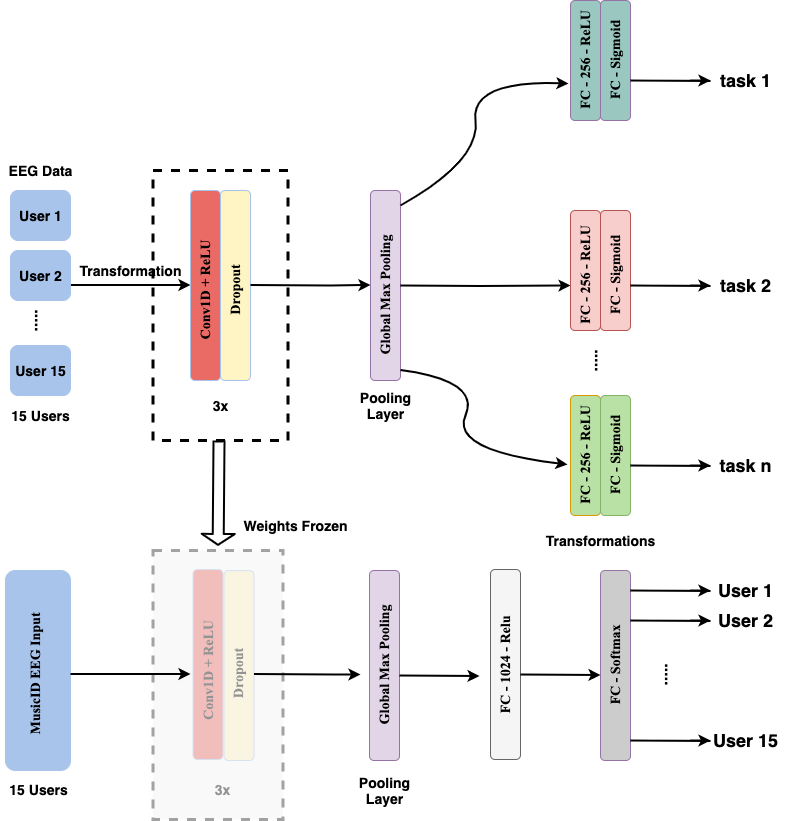

#### Upstream of self-supervsied learning model

In [ ]:
class Upstream_Module(nn.Module):
    def __init__(self, task_nums=11):
        super(Upstream_Module, self).__init__()

        self.features = nn.Sequential(
                        nn.Conv1d(16, 32, kernel_size=12),
                        nn.Dropout(p = 0.2),             
                        nn.ReLU(),
                        nn.Conv1d(32, 64, kernel_size=8),
                        nn.Dropout(p = 0.2), 
                        nn.ReLU(),
                        nn.Conv1d(64, 96, kernel_size=4),
                        nn.Dropout(p = 0.2), 
                        nn.ReLU(),
                        )
        
        self.tasks = nn.ModuleList([copy.deepcopy(nn.Sequential(nn.Linear(96, 256),
                       nn.Dropout(p=0.2),           
                       nn.ReLU(),
                       nn.Linear(256, 1))) for _ in range(task_nums)])
        
    def forward(self, x):
        out = self.features(x)

        # Global max pooling
        globalMaxPooling = nn.AdaptiveMaxPool1d(1)
        out = globalMaxPooling(out)
        
        #flatten
        out = torch.flatten(out, 1)
        all_out = [torch.sigmoid(task_model(out)) for task_model in self.tasks]
        
        return all_out

In [ ]:
upstream_net = Upstream_Module()
use_gpu = torch.cuda.is_available()

if use_gpu:
  upstream_net = upstream_net.cuda()
  
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(upstream_net.parameters(), lr = 0.0003, betas = (0.9, 0.999), weight_decay=0.0001, eps = 1e-08, amsgrad = False)

##### Please leave no space on the directory path when changing the file path. 

In [ ]:
# Data loader
mydata = MyData('/content/Final_Case1_15_users/TrainingSet/')
train_loader = DataLoader(mydata, batch_size=256, shuffle=True)

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [ ]:
def fit(net, criterion, optimizer, batchsize=256, epochs=20, threshold=0.5, t_nums=11):
    acc_list = []
    loss_list = []

    for epoch in range(epochs):
        acc_total = 0
        loss_total = 0
        count = 1
        recall_all = np.zeros(t_nums)
        precision_all = np.zeros(t_nums)
        net.train()

        for train_data in train_loader:
            train_X, train_y = train_data
            train_y_new = train_y.view(-1, 1, t_nums)
            train_X_new = train_X.permute(0, 2, 1)
            train_X_new = train_X_new.to(torch.float32)
            train_y_new = train_y_new.to(torch.float32)

            if use_gpu:
              train_X_new = train_X_new.cuda()
              train_y_new = train_y_new.cuda()
            optimizer.zero_grad()
            all_out = net.forward(train_X_new)
            loss_f = 0
            for i in range(len(all_out)):
              loss_f += criterion(all_out[i], train_y_new[:, :, i])
            loss = loss_f
            loss.backward()
            optimizer.step()
          
            # acc
            out = torch.cat(all_out, 1)
            out_new = out.reshape(-1, 1, len(all_out))
            train_y_new_max = torch.argmax(train_y_new, dim=2, keepdim=False)
            out_new_max = torch.argmax(out_new, dim=2, keepdim=False)
            count += 1
            acc_total += sum(train_y_new_max.flatten() == out_new_max.flatten())/ (out_new_max.shape[0]) * 100
            loss_total += loss

            for i in range(len(all_out)):
              out_temp = out[:, i].detach().cpu().numpy()
              out_temp[out_temp<threshold]=0
              out_temp[out_temp>=threshold]=1
              result_temp = train_y_new[:,:,i].flatten().cpu().numpy()
              recall_all[i] += recall_score(result_temp.astype(int), out_temp.flatten().astype(int))
              precision_all[i] += precision_score(out_temp.flatten().astype(int), result_temp.astype(int))

        acc_mean = float(acc_total / count)
        loss_mean = float(loss_total / count)
        acc_list.append(acc_mean)
        loss_list.append(loss_mean)
        print("epoch: {}----loss: {}------acc: {}".format(epoch+1, loss_mean, acc_mean))
        print("precision: {:}".format(precision_all/count))
        print("recall: {:}".format(recall_all/count))
        
    return loss_list, acc_list

In [ ]:
 upstream_loss, upstream_acc = fit(net = upstream_net, criterion=criterion, optimizer=optimizer, epochs=5)

epoch: 1----loss: 1.7018537521362305------acc: 47.46866226196289
precision: [0.         0.         0.96825011 0.86577836 0.         0.76663909
 0.         0.65009833 0.97941889 0.         0.        ]
recall: [0.         0.         0.96825011 0.86577836 0.         0.76663909
 0.         0.65009833 0.97941889 0.         0.        ]
epoch: 2----loss: 1.6330969333648682------acc: 48.693504333496094
precision: [0.         0.         0.97941469 0.8763957  0.         0.81525815
 0.         0.76606171 0.97884779 0.         0.        ]
recall: [0.         0.         0.97941469 0.8763957  0.         0.81525815
 0.         0.76606171 0.97884779 0.         0.        ]
epoch: 3----loss: 1.5940440893173218------acc: 49.21875
precision: [0.         0.         0.98115049 0.88557672 0.         0.83582995
 0.         0.81305503 0.98072394 0.         0.        ]
recall: [0.         0.         0.98115049 0.88557672 0.         0.83582995
 0.         0.81305503 0.98072394 0.         0.        ]
epoch: 4----

#### Weights Frozen

In [ ]:
# save the upstream model
PATH = '/content/Upstream.pt' 
torch.save(upstream_net.state_dict(),PATH)

# load the upstream model
model = Upstream_Module()
model.load_state_dict(torch.load(PATH))
new_model = torch.nn.Sequential(*(list(model.children())[0:1]))
new_model.eval()

Sequential(
  (0): Sequential(
    (0): Conv1d(16, 32, kernel_size=(12,), stride=(1,))
    (1): Dropout(p=0.2, inplace=False)
    (2): ReLU()
    (3): Conv1d(32, 64, kernel_size=(8,), stride=(1,))
    (4): Dropout(p=0.2, inplace=False)
    (5): ReLU()
    (6): Conv1d(64, 96, kernel_size=(4,), stride=(1,))
    (7): Dropout(p=0.2, inplace=False)
    (8): ReLU()
  )
)

#### Downstream of supervised learning model


In [ ]:
class Downstream_Module(nn.Module):
    def __init__(self):
        super(Downstream_Module, self).__init__()

        self.features = nn.Sequential(
                        nn.Linear(96, 512),
                        nn.Dropout(p = 0.2),
                        nn.ReLU(),
                        nn.Linear(512, 15),
                        )
      
    def forward(self, x):
        out = new_model(x)
        # Global max pooling
        globalMaxPooling = nn.AdaptiveMaxPool1d(1)
        out = globalMaxPooling(out)
        # flatten
        out = torch.flatten(out, 1)
        out = self.features(out)
        return out

In [ ]:
class downstream_dataloader(Dataset):
  def __init__(self,content_path,window_size=30,overlap=0.7,scale_p=0.2,rotation_scale=-1,excute_rate=1,keep_rate=1):
    super(downstream_dataloader,self).__init__()
    self.index_reference = ['user1','user2','user3','user4','user5','user6','user7','user8','user9','user10','user11','user12','user13','user14','user15']
    all_data = []
    all_label = []
    indi_files = os.listdir(content_path)

    for ind_file in indi_files:
      if ind_file.endswith('.csv'):
        file_name = os.path.join(content_path,ind_file)
        single_file_data = single_file_cup(file_name, window_size, overlap, start_ix = 5,end_ix= 21, keep_rate = keep_rate)
        f_file_name = file_name.split('/')[-1].split('_')[0]
        label_index = self.index_reference.index(f_file_name)
        all_data.extend(single_file_data)  
        all_label.extend([label_index for _ in range(len(single_file_data))])
        
    all_data = np.array(all_data).reshape(-1, window_size, 16)
    all_label = np.array(all_label)
    self.new_data = []
    self.label = []

    for i in range(len(all_data)):
      s_data = all_data[i]
      s_label = all_label[i]
      self.new_data.extend([s_data])
      self.label.extend([s_label])

      noise_rate = random.random()
      if noise_rate > excute_rate:
        noised_data = add_noise(s_data,'factor',scale_p)
        self.new_data.extend([noised_data])
        self.label.extend([s_label])

      scale_rate = random.random()
      if scale_rate > excute_rate:
        scaled_data = scale(s_data,scale_p)
        self.new_data.extend([scaled_data])
        self.label.extend([s_label])

      flip_rate = random.random()
      if scale_rate > excute_rate:
        flip_data = horizon_flip(s_data)
        self.new_data.extend([flip_data])
        self.label.extend([s_label])

      rotate_rate = random.random()
      if rotate_rate > excute_rate:
        roatated_data = rotation(s_data,scale_p)
        self.new_data.extend([roatated_data])
        self.label.extend([s_label])

    self.new_data = np.array(self.new_data)
    self.label = np.array(self.label)

  def __len__(self):
    return len(self.new_data)
  
  def __getitem__(self,index):
    input_data = self.new_data[index]
    input_label = self.label[index]
    return input_data, input_label

In [ ]:
keeping_rate = [0.05,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]
downstream_mydata = downstream_dataloader('/content/Case2-5users/TrainingSet/',keep_rate=1)
downstream_testdata = downstream_dataloader('/content/Case2-5users/TestingSet/')

ds_train_loader = DataLoader(downstream_mydata, batch_size=256, shuffle=True)
# ds_vali_loader = DataLoader(ds_data_vali, batch_size=128, shuffle=True)
ds_test_loader = DataLoader(downstream_testdata, batch_size=64, shuffle=True)

In [ ]:
def get_pt_file(keep_rate1):
    downstream_mydata = downstream_dataloader('/content/Case2-5users/TrainingSet/',keep_rate=keep_rate1)
    downstream_testdata = downstream_dataloader('/content/Case2-5users/TestingSet/')
    accuracy_dic = {}

    ds_train_loader = DataLoader(downstream_mydata, batch_size=256, shuffle=True)
    # ds_vali_loader = DataLoader(ds_data_vali, batch_size=128, shuffle=True)
    ds_test_loader = DataLoader(downstream_testdata, batch_size=64, shuffle=True)
    downstream_net = Downstream_Module()

    # if use_gpu:
    #   downstream_net.cuda()
    downstream_optimizer = torch.optim.Adam(downstream_net.parameters(),weight_decay=0.0001)                             
    downstream_criterion = torch.nn.CrossEntropyLoss()
    loss_list = []
    acc_list = []

    for epoch in range(1500):
      accuracy_list = list()
      downstream_net.train()
      for train_data in ds_train_loader:
        output_label = []
        train_X, train_y = train_data
        train_X_new = train_X.permute(0, 2, 1)
        train_X_new = train_X_new.to(torch.float32)
        train_y_new = train_y.to(torch.long)

        # if use_gpu:
        #   train_X_new.cuda()
        #   train_y_new.cuda()
        
        downstream_optimizer.zero_grad()
        output = downstream_net(train_X_new)
        loss = downstream_criterion(output, train_y_new)
        loss.backward()
        downstream_optimizer.step()

        # tensor -> numpy
        y_hat = output.argmax(dim=1).cpu().numpy()
        label = train_y_new.cpu().numpy()

        # accuracy
        accuracy = np.sum(y_hat==label)/len(label)
        accuracy_list.append(accuracy.item())
        loss_list.append(loss)
        acc_list.append(sum(accuracy_list)/len(accuracy_list))
        
      validation_list = list()
      with torch.no_grad():
        downstream_net.eval()
        
        for vali_data in ds_test_loader:
          output_label = []
          test_X, test_y = vali_data
          test_X_new = test_X.permute(0, 2, 1)
          test_X_new = test_X_new.to(torch.float32)
          test_y_new = test_y.to(torch.long)

          # if use_gpu:
          #   test_X_new.cuda()
          #   test_y_new.cuda()

          test_output = downstream_net(test_X_new)
          test_y_hat = test_output.argmax(dim=1).cpu().numpy()
          test_label = test_y_new.cpu().numpy()

          # accuracy
          test_accuracy = np.sum(test_y_hat==test_label)/len(test_label)
          validation_list.append(test_accuracy.item())
          
    vali_accu = 100*(sum(validation_list)/len(validation_list))
    PATH = '/content/'+str(keep_rate1)+'Case2Downstream.pt' 
    torch.save(downstream_net.state_dict(),PATH)
    print('Epoch {} ----- loss: {:.5f} ----- accuracy: {:.3f}%' \
            .format(epoch+1, loss.item(), 100*(sum(accuracy_list)/len(accuracy_list))))
    print('Validation Epoch {} accuracy: {:.3f}%' \
            .format(epoch+1, 100*(sum(validation_list)/len(validation_list))))
    
    return vali_accu


#### Accuracies under different training datasize situations

In [ ]:
def get_acculist():
    keeping_rate = [0.05,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]
    accu_dic = {}
    for rate in keeping_rate:
      accu_dic[rate] = get_pt_file(rate)
    accu_list = list(accu_dic.values())
    return accu_list

In [ ]:
accu_list = get_acculist()

Epoch 1500 ----- loss: 0.01353 ----- accuracy: 100.000%
Validation Epoch 1500 accuracy: 48.000%
Epoch 1500 ----- loss: 0.01325 ----- accuracy: 100.000%
Validation Epoch 1500 accuracy: 68.000%
Epoch 1500 ----- loss: 0.02406 ----- accuracy: 100.000%
Validation Epoch 1500 accuracy: 72.000%
Epoch 1500 ----- loss: 0.03220 ----- accuracy: 100.000%
Validation Epoch 1500 accuracy: 80.000%
Epoch 1500 ----- loss: 0.03133 ----- accuracy: 100.000%
Validation Epoch 1500 accuracy: 84.000%
Epoch 1500 ----- loss: 0.08378 ----- accuracy: 98.278%
Validation Epoch 1500 accuracy: 96.000%
Epoch 1500 ----- loss: 0.08275 ----- accuracy: 98.404%
Validation Epoch 1500 accuracy: 96.000%
Epoch 1500 ----- loss: 0.02818 ----- accuracy: 99.805%
Validation Epoch 1500 accuracy: 96.000%
Epoch 1500 ----- loss: 0.02611 ----- accuracy: 99.772%
Validation Epoch 1500 accuracy: 96.000%
Epoch 1500 ----- loss: 0.02785 ----- accuracy: 99.349%
Validation Epoch 1500 accuracy: 96.000%
Epoch 1500 ----- loss: 0.02410 ----- accuracy

In [ ]:
def downstream_test():
    downstream_net.eval()

    test_accuracy_list = list()

    for test_data in ds_test_loader:
        output_label = []
        test_X, test_y = test_data
        test_X_new = test_X.permute(0, 2, 1)
        test_X_new = test_X_new.to(torch.float32)
        test_y_new = test_y.to(torch.long)

        # if use_gpu:
        #   test_X_new.cuda()
        #   test_y_new.cuda()
        
        # downstream_optimizer.zero_grad()
        test_output = downstream_net(test_X_new)

        # tensor -> numpy
        test_y_hat = test_output.argmax(dim=1).cpu().numpy()
        print("test_y_hat: ", test_y_hat)
        test_label = test_y_new.cpu().numpy()
        print("test_label: ", test_label)

        # accuracy
        test_accuracy = np.sum(test_y_hat==test_label)/len(test_label)
        print("test_accuracy: ", test_accuracy)
        test_accuracy_list.append(test_accuracy.item())
        test_acc = (100*(sum(test_accuracy_list)/len(test_accuracy_list)))
    return test_acc

#### Self-supervised learning Plot

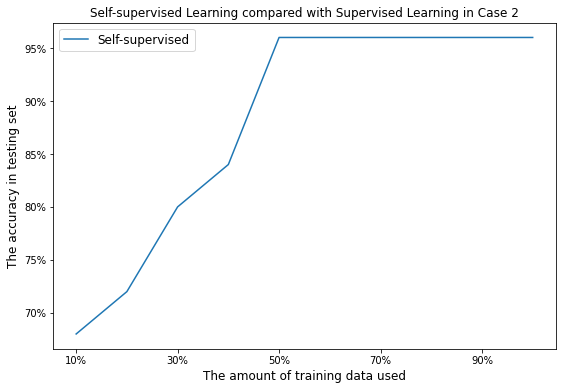

In [ ]:
from matplotlib.ticker import FuncFormatter
plt.figure(figsize=(9,6))
plt.plot(accu_list[1:])
def to_percent(temp, position):
  return '%1.0f'%(10*temp+10) + '%'
def y_to_percent(temp, position):
  return '%2.0f'%(temp) + '%'
plt.gca().yaxis.set_major_formatter(FuncFormatter(y_to_percent))
plt.gca().xaxis.set_major_formatter(FuncFormatter(to_percent))
plt.xlabel('The amount of training data used',fontsize=12)
plt.ylabel('The accuracy in testing set',fontsize=12)
plt.title('Self-supervised Learning compared with Supervised Learning in Case 2',fontsize=12)
plt.legend(['Self-supervised'],loc='best',prop={'size':12})
plt.show()

In [ ]:
PATH = '/content/Case2Downstream.pt' 
torch.save(downstream_net.state_dict(),PATH)

#### The Final Result of comparasion of three models.


In [ ]:
self_supervised_list = [0.86, 0.86, 0.86, 0.84, 0.86, 0.84, 0.78, 0.74, 0.58, 0.56]
supervised_list = [0.86, 0.84, 0.76, 0.78, 0.74, 0.76, 0.74, 0.70, 0.60, 0.54]
secrete_test = [0.92, 0.92, 0.86, 0.84, 0.82, 0.78, 0.68, 0.68, 0.60, 0.59]
self_supervised_list.reverse()
supervised_list.reverse()
secrete_test.reverse()
final_dic = {"Self-supervised model with Case-1 data":{"10% data size": 0.56,"20% data size":0.58, "30% data size": 0.74,"40% data size": 0.78,"50% data size": 0.84,"60% data size": 0.86,"70% data size": 0.84,"80% data size": 0.86,"90% data size": 0.86,"100% data size": 0.86 },
                               "Supervised model with Case-1 data":{"10% data size":0.54,"20% data size":0.6, "30% data size": 0.70,"40% data size": 0.74,"50% data size": 0.76,"60% data size": 0.74,"70% data size": 0.78,"80% data size": 0.76,"90% data size": 0.84,"100% data size": 0.86 },
                               "Self-supervised model with Case1 Secret data":{"10% data size":0.59,"20% data size":0.60, "30% data size": 0.68,"40% data size":  0.68,"50% data size": 0.78,"60% data size": 0.82,"70% data size": 0.84,"80% data size": 0.86,"90% data size": 0.92,"100% data size": 0.92 }}
final_df=pd.DataFrame(final_dic)
final_df

,Self-supervised model with Case-1 data,Supervised model with Case-1 data,Self-supervised model with Case1 Secret data
10% data size,0.56,0.54,0.59
20% data size,0.58,0.60,0.60
30% data size,0.74,0.70,0.68
40% data size,0.78,0.74,0.68
50% data size,0.84,0.76,0.78
60% data size,0.86,0.74,0.82
70% data size,0.84,0.78,0.84
80% data size,0.86,0.76,0.86
90% data size,0.86,0.84,0.92
100% data size,0.86,0.86,0.92


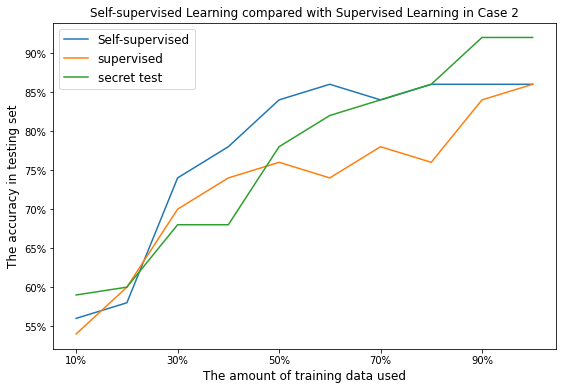

In [ ]:
from matplotlib.ticker import FuncFormatter
plt.figure(figsize=(9,6))
plt.plot(self_supervised_list)
plt.plot(supervised_list)
plt.plot(secrete_test)
def to_percent(temp, position):
  return '%1.0f'%(10*temp+10) + '%'
def y_to_percent(temp, position):
  return '%2.0f'%(100*temp) + '%'
plt.gca().yaxis.set_major_formatter(FuncFormatter(y_to_percent))
plt.gca().xaxis.set_major_formatter(FuncFormatter(to_percent))
plt.xlabel('The amount of training data used',fontsize=12)
plt.ylabel('The accuracy in testing set',fontsize=12)
plt.title('Self-supervised Learning compared with Supervised Learning in Case 2',fontsize=12)
plt.legend(['Self-supervised', 'supervised', 'secret test'],loc='best',prop={'size':12})
plt.show()